## 5. CRISP-DM: Modeling

## Training and Evaluation without SMOTE

Evaluating initial models:


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


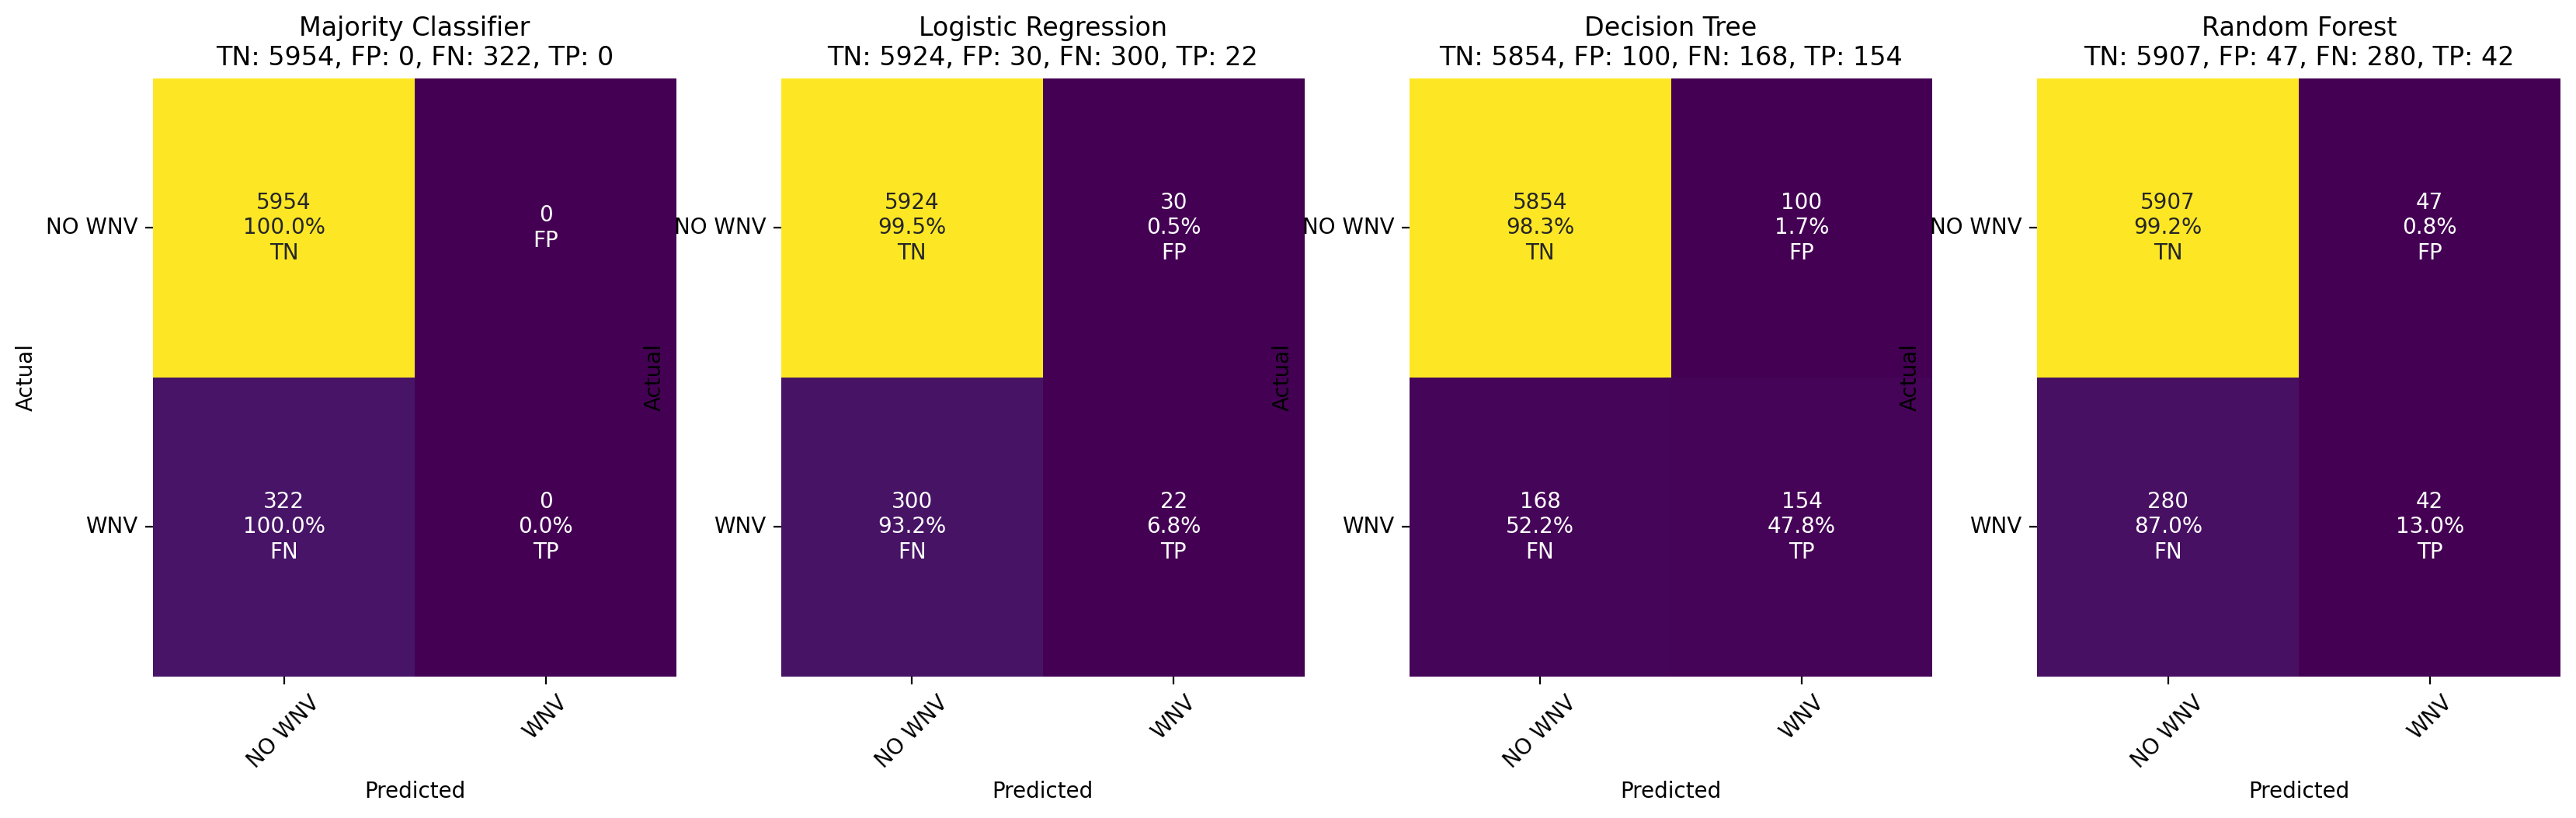

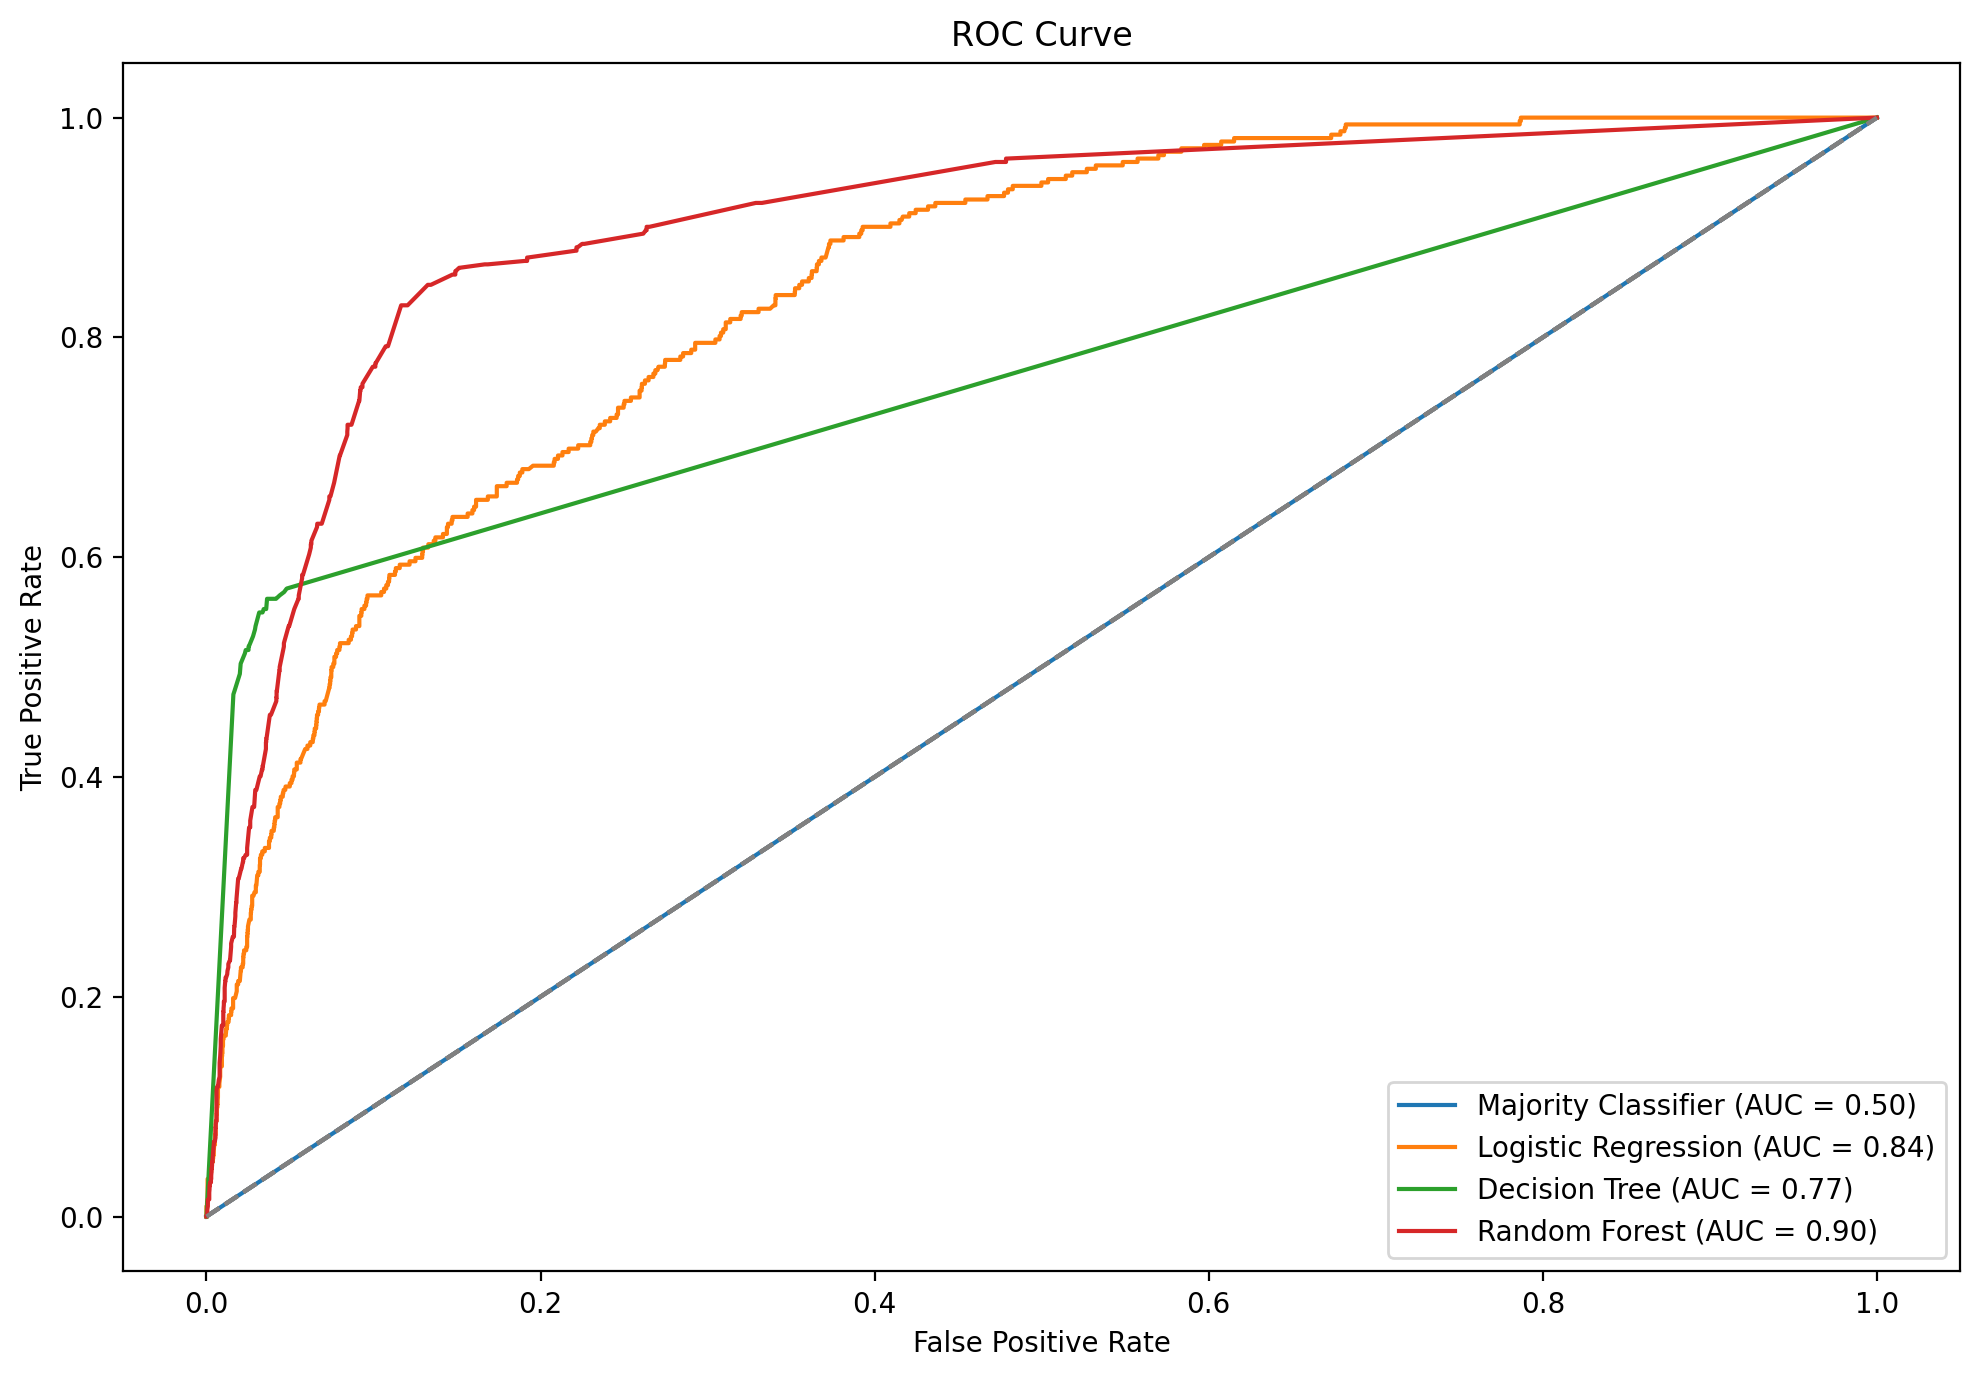

,Accuracy,ROC AUC,F1 Score,Precision,Recall
Majority Classifier,0.948693,0.500000,0.000000,0.000000,0.000000
Logistic Regression,0.947419,0.844296,0.117647,0.423077,0.068323
Decision Tree,0.957298,0.768957,0.534722,0.606299,0.478261
Random Forest,0.947897,0.902537,0.204380,0.471910,0.130435


Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Evaluating hyperparameter-tuned models:


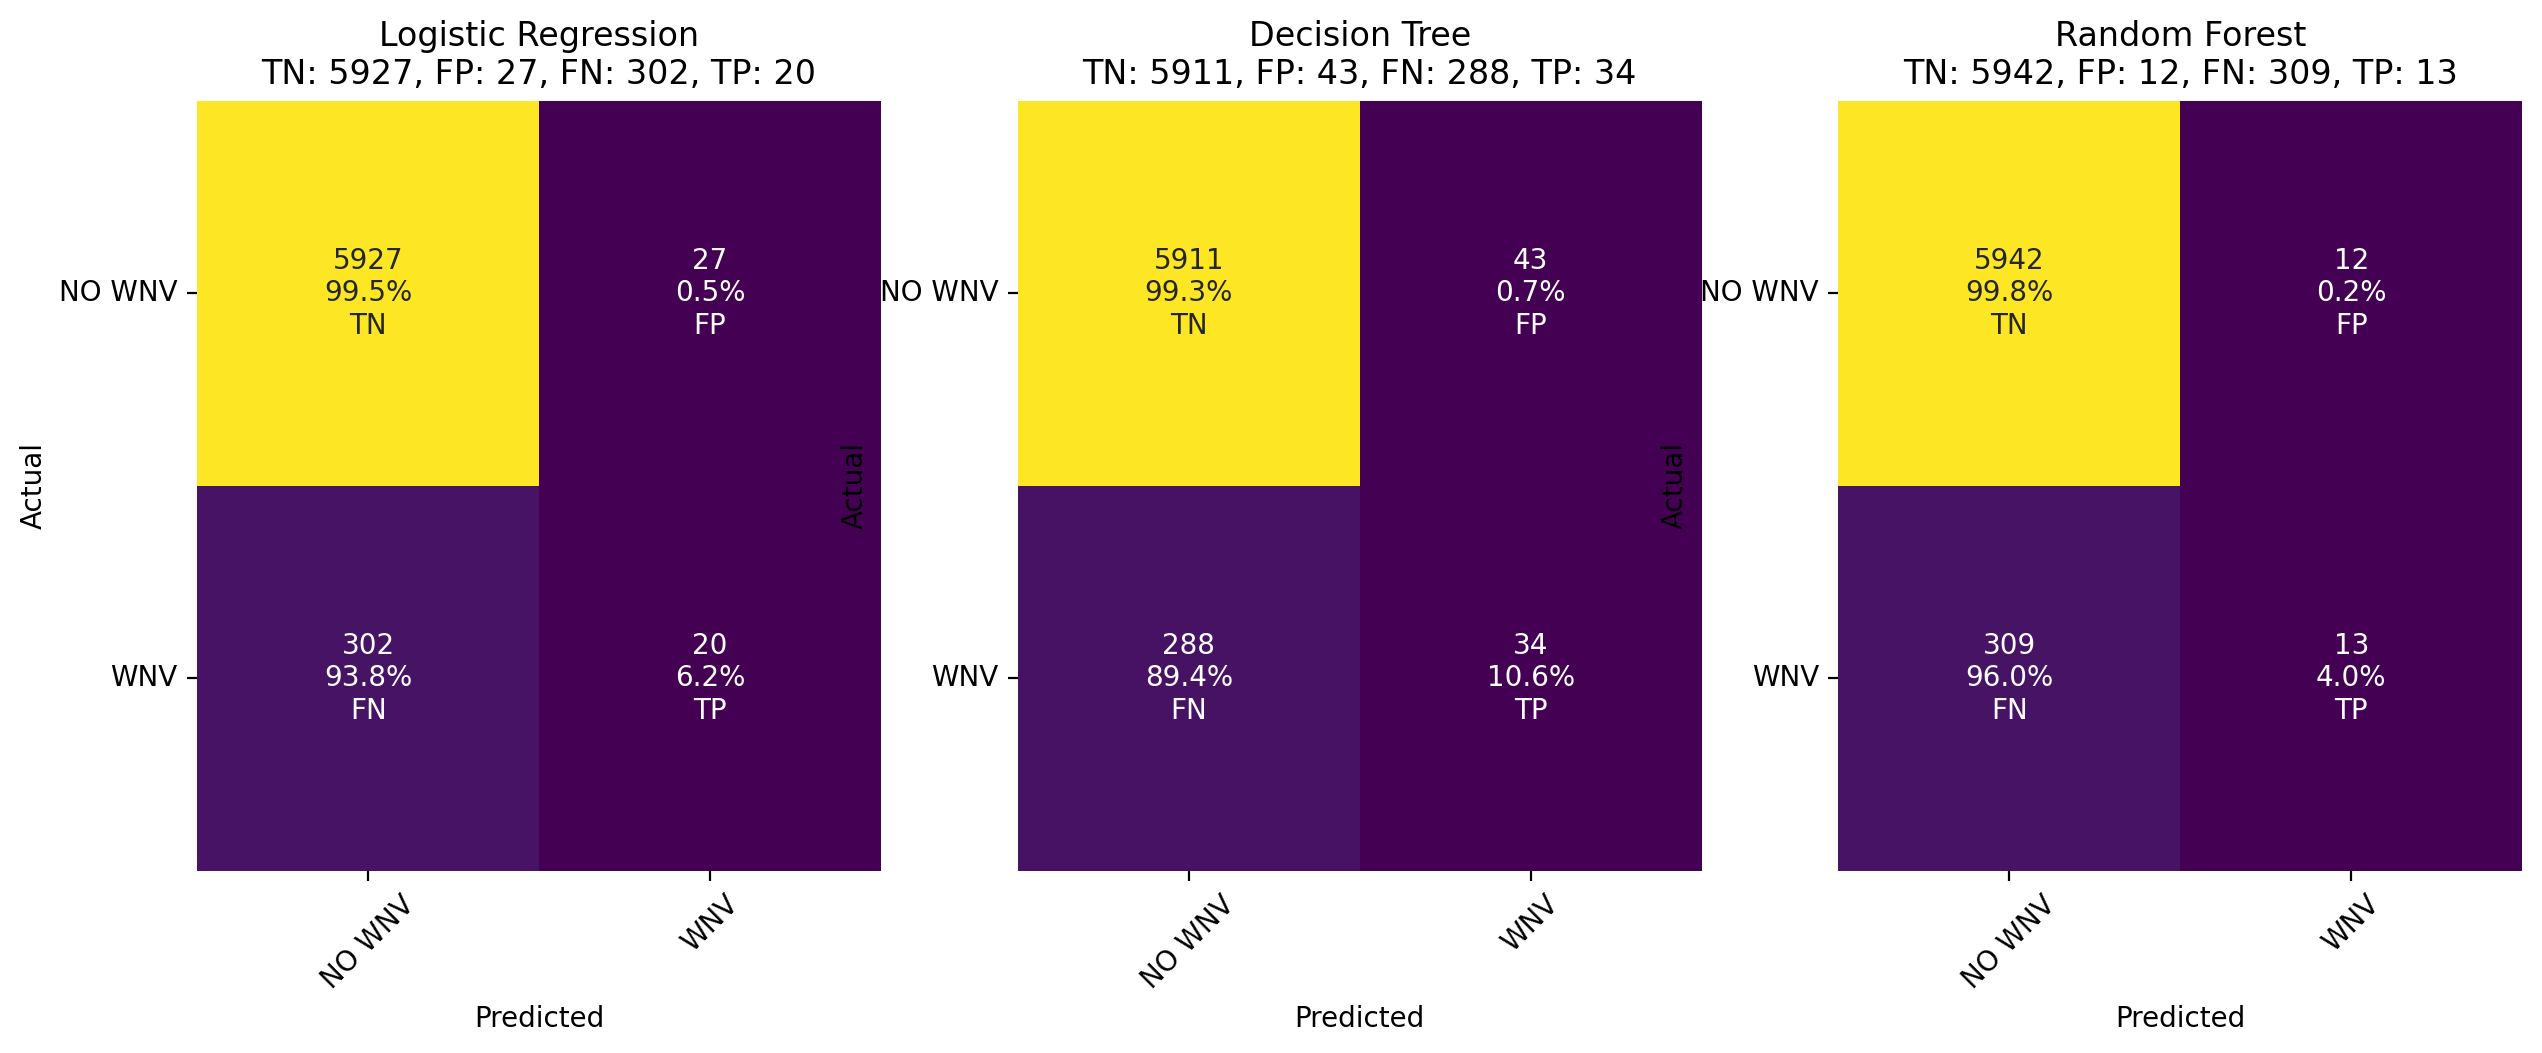

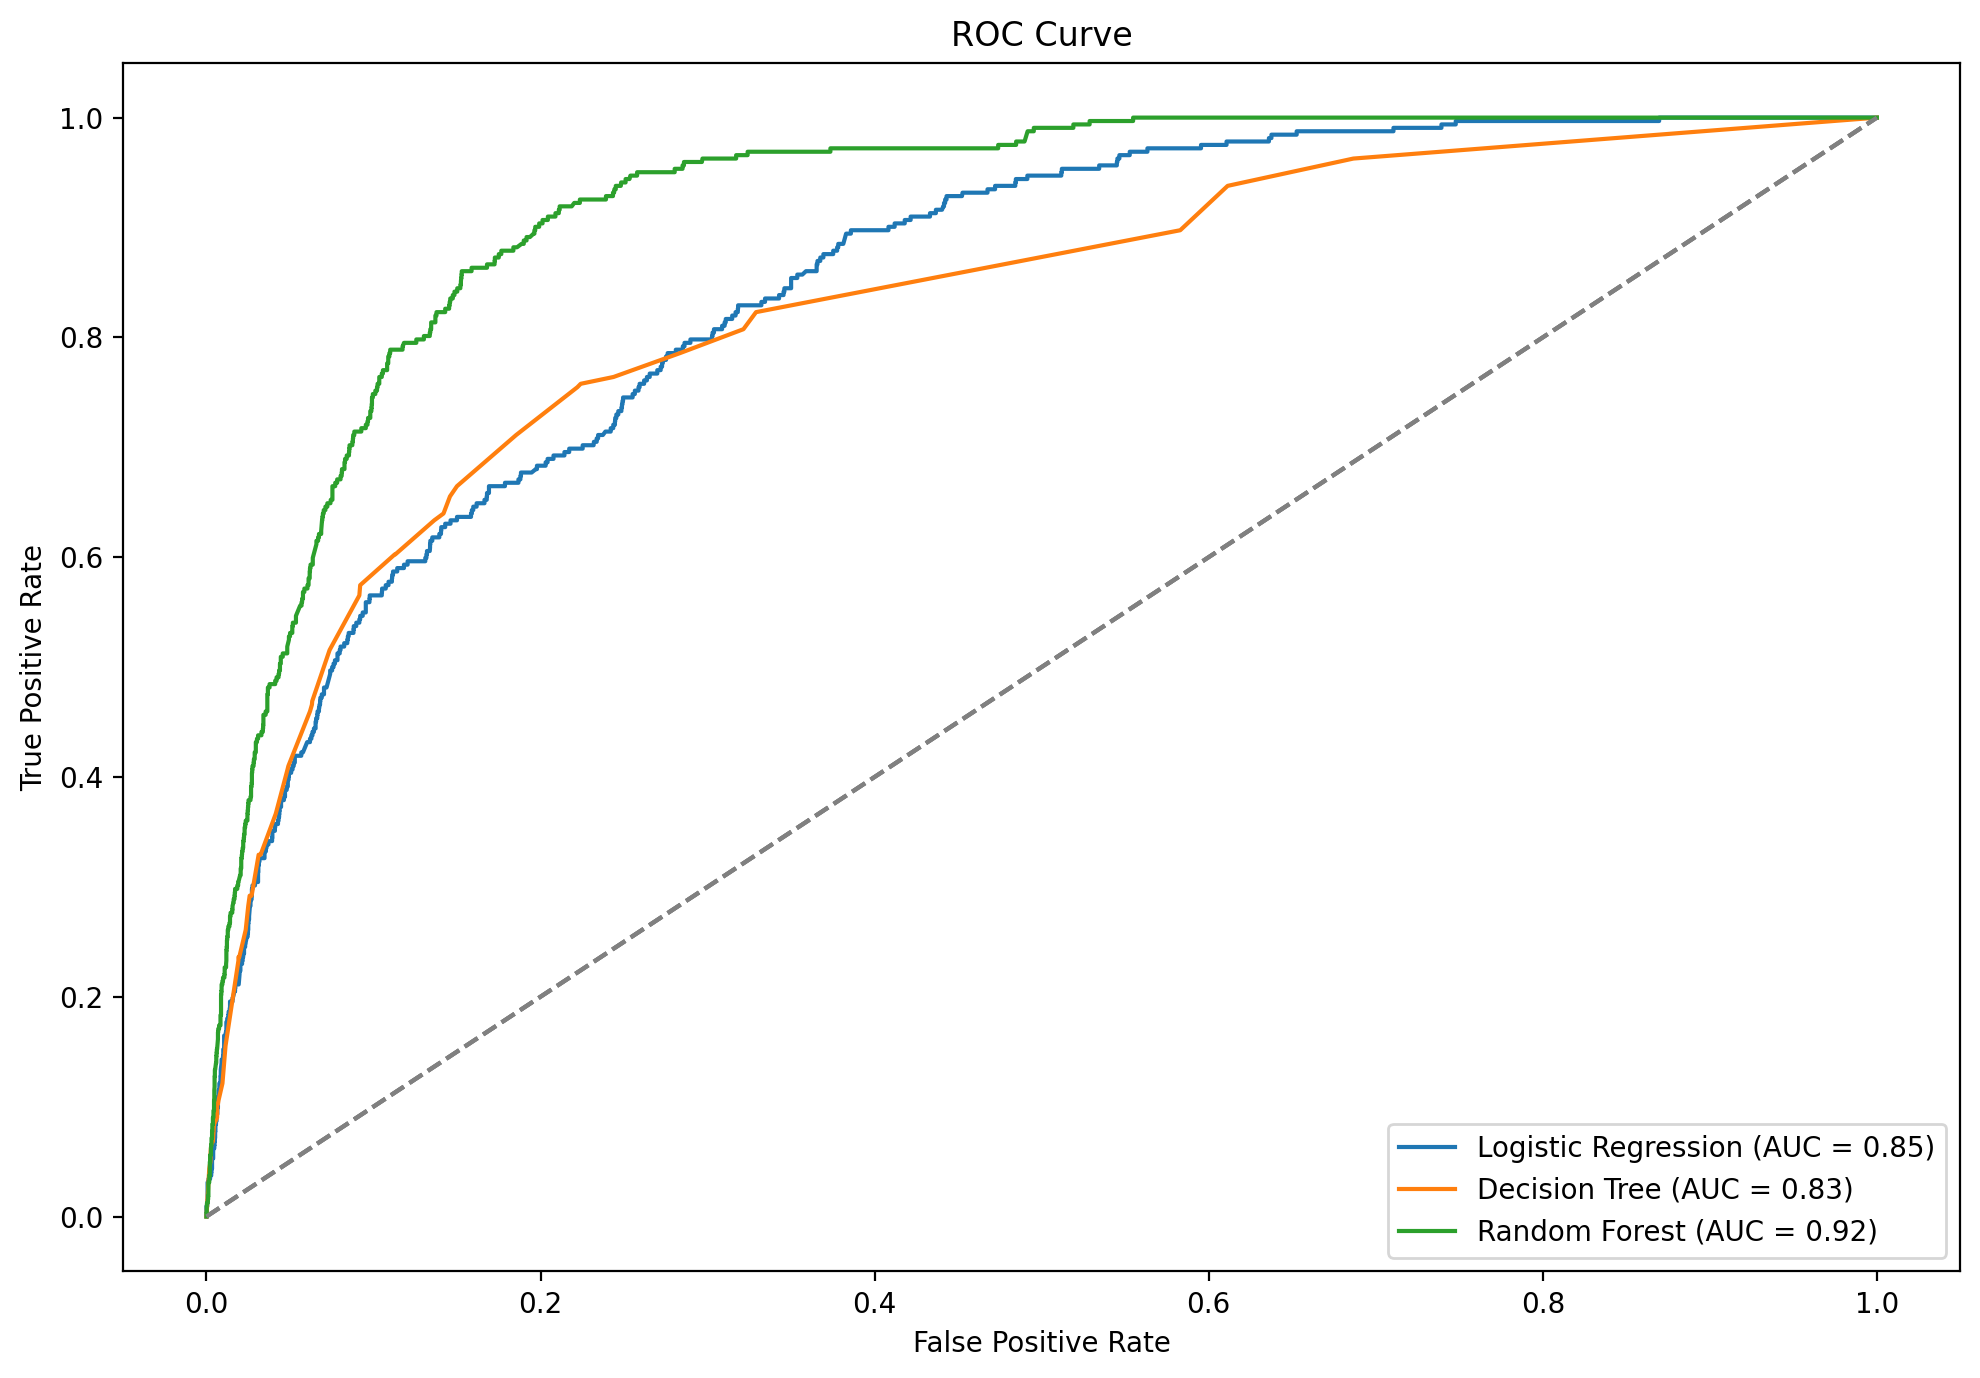

,Accuracy,ROC AUC,F1 Score,Precision,Recall
Logistic Regression,0.947578,0.845180,0.108401,0.425532,0.062112
Decision Tree,0.947259,0.827708,0.170426,0.441558,0.105590
Random Forest,0.948853,0.920882,0.074928,0.520000,0.040373


Cross-Validation Scores for RandomForestClassifier(max_depth=20, n_estimators=200): [0.88849205 0.9098877  0.90829265 0.91372401 0.90516544]
Mean CV Score: 0.91
Submission file created successfully.


## Training and Evaluation with SMOTE

Evaluating initial models:


c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


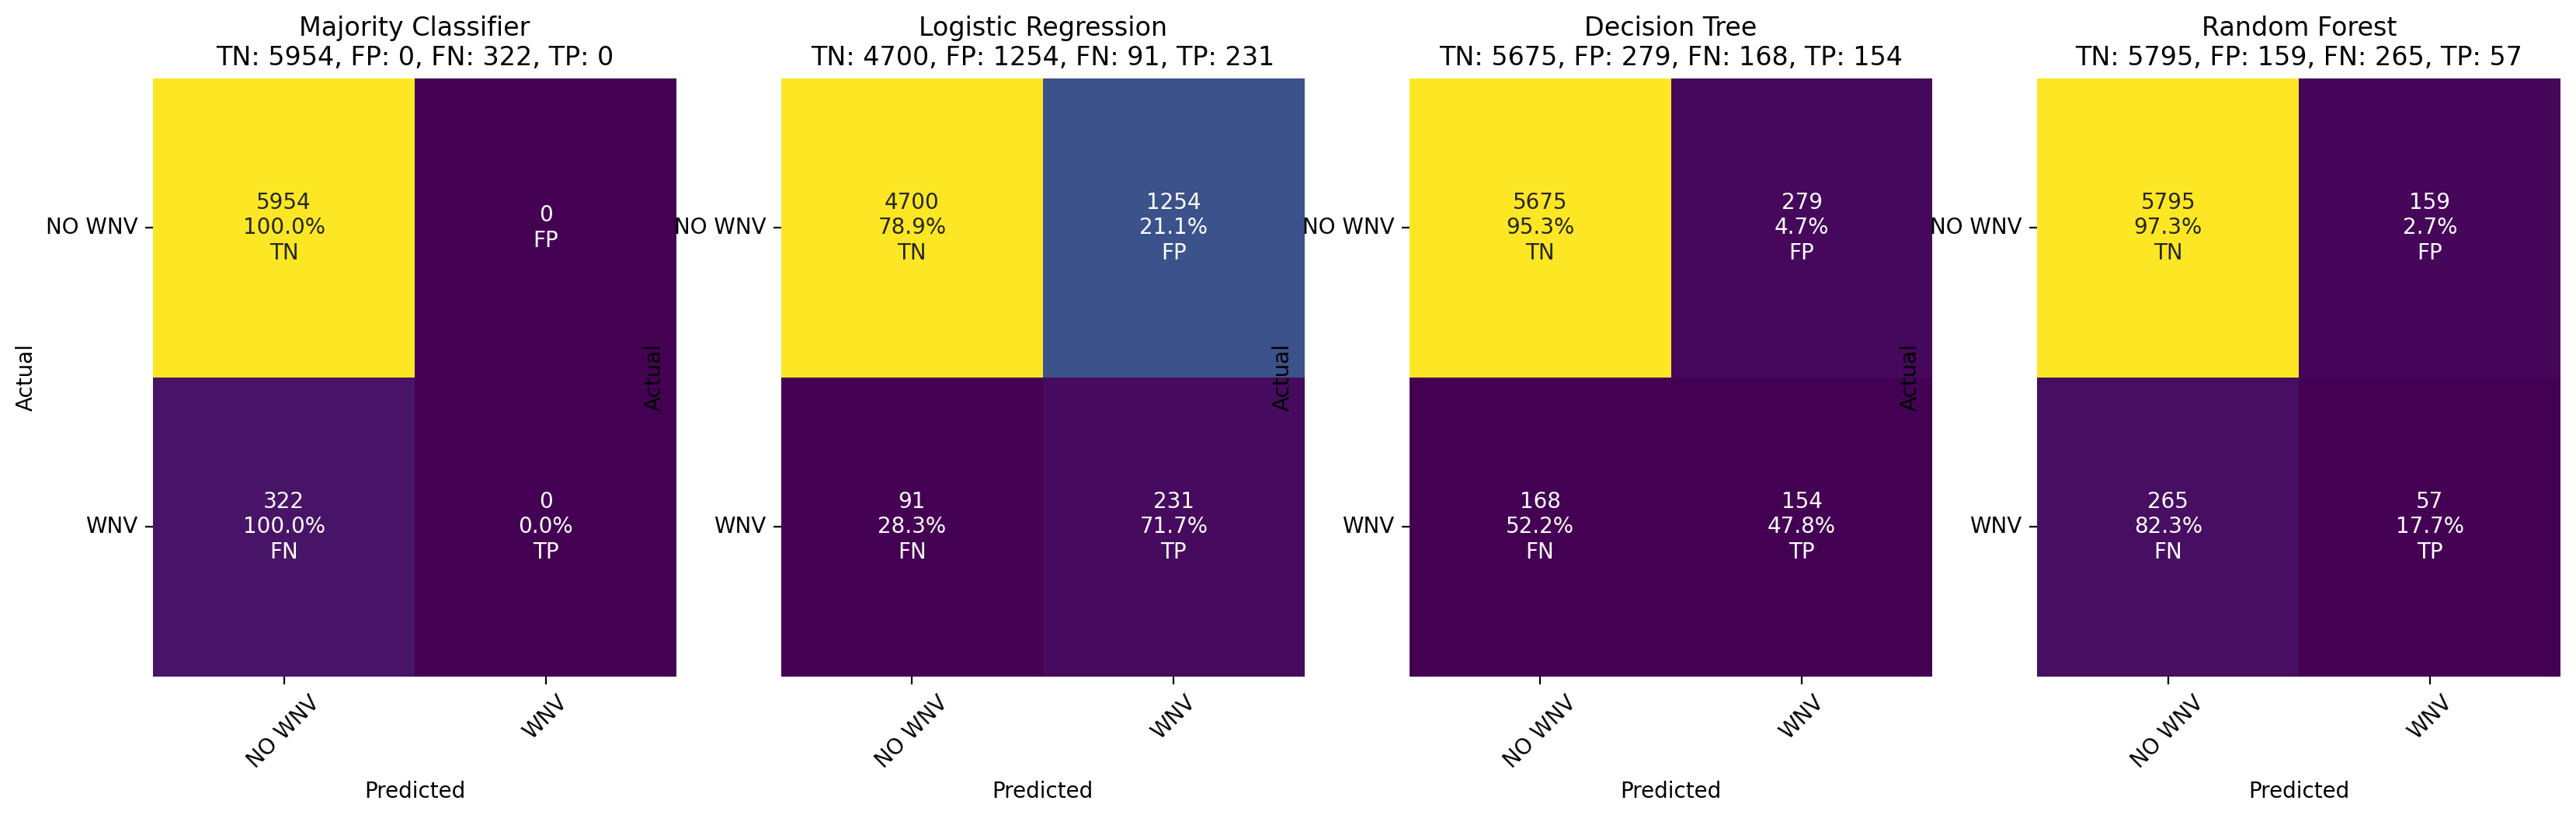

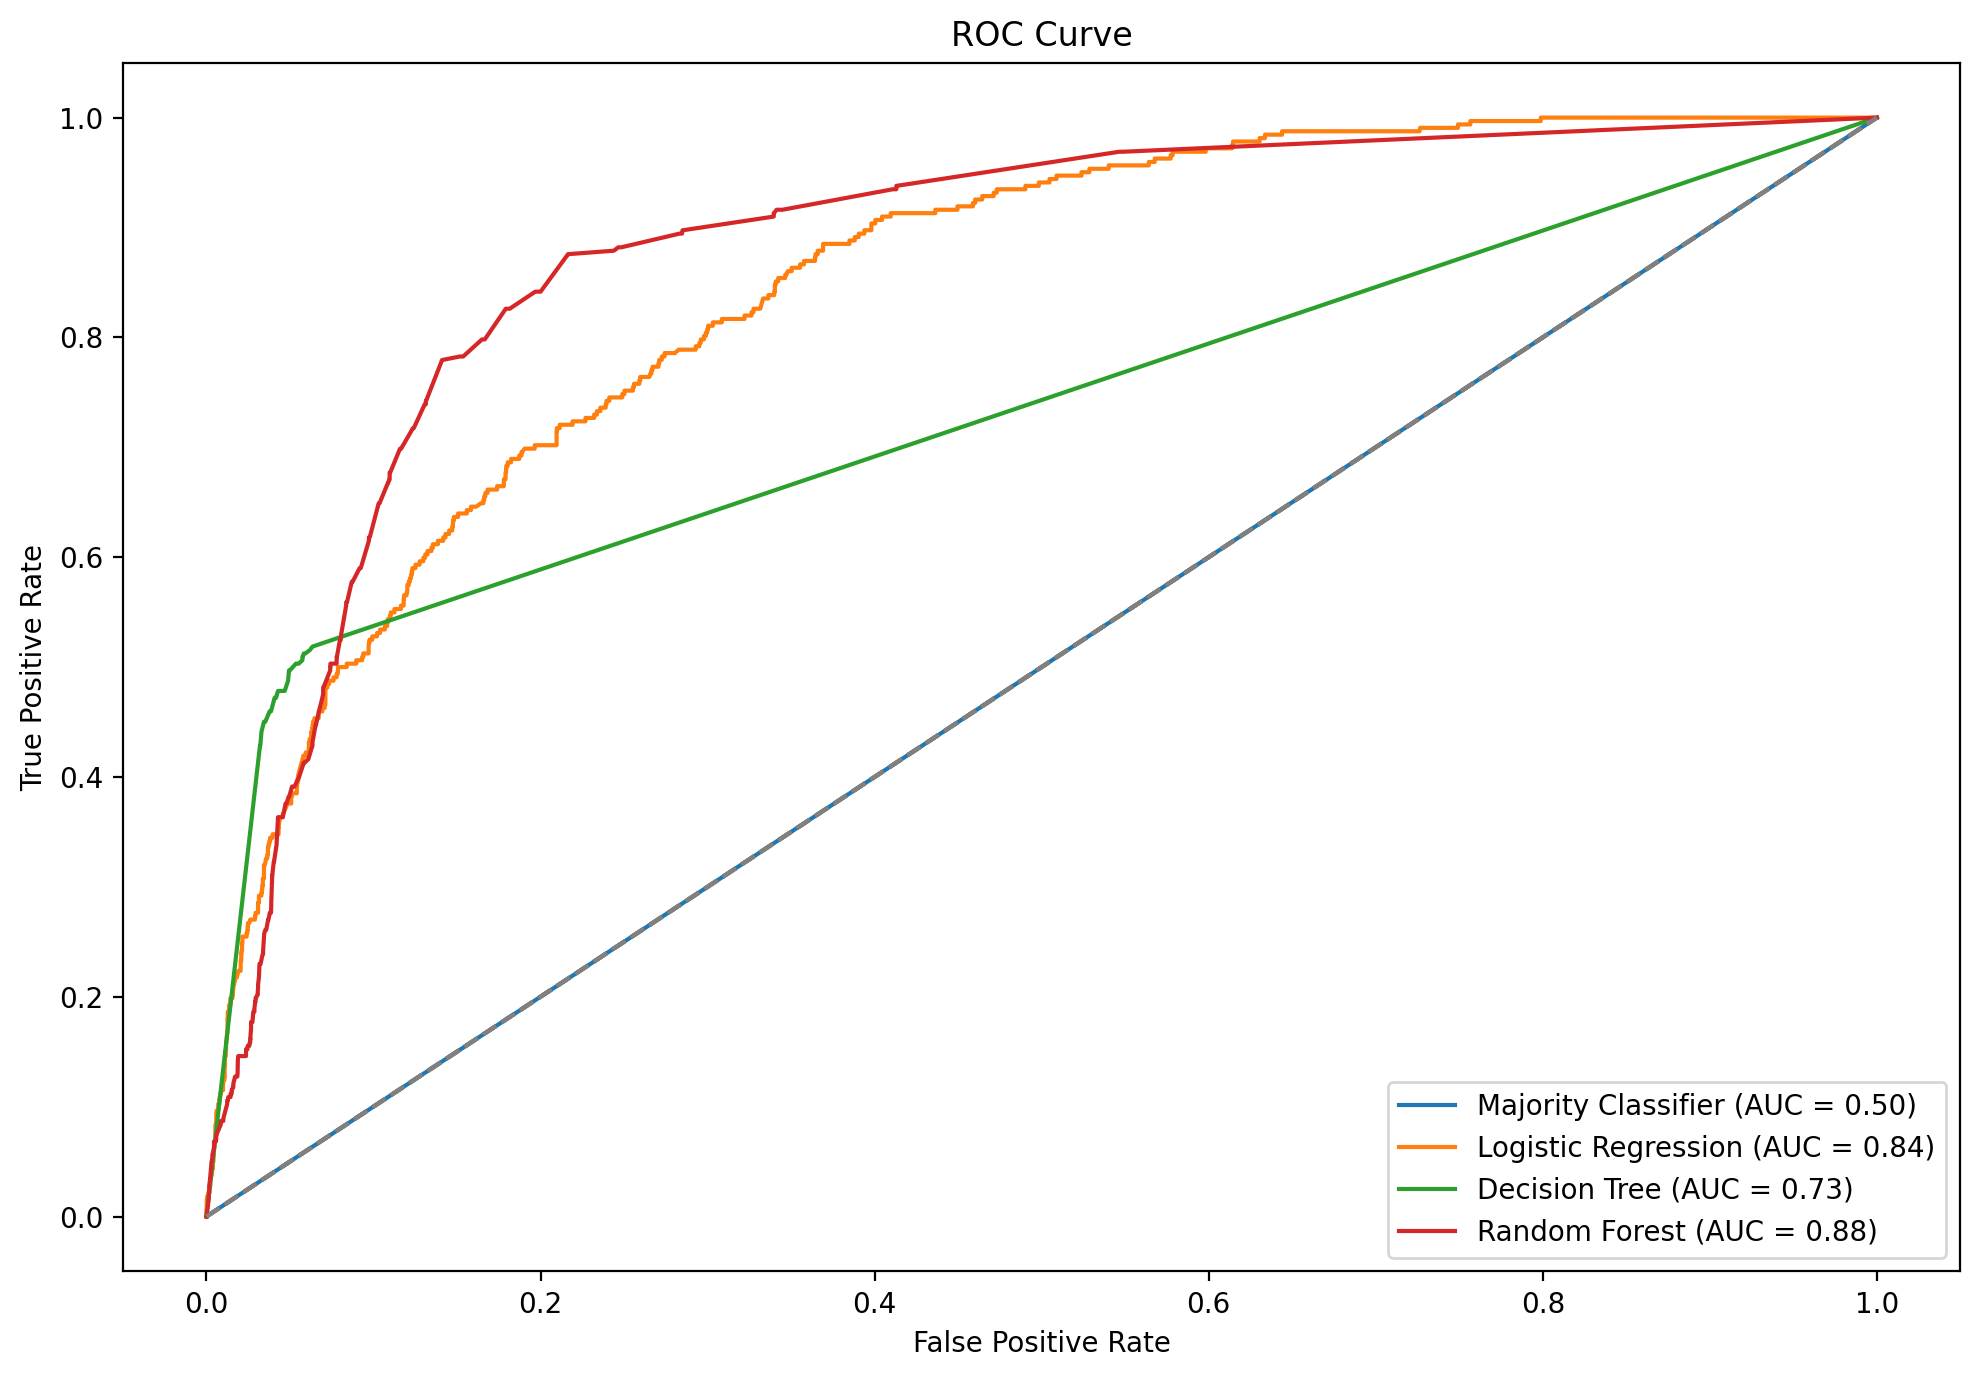

,Accuracy,ROC AUC,F1 Score,Precision,Recall
Majority Classifier,0.948693,0.500000,0.000000,0.000000,0.000000
Logistic Regression,0.785692,0.844153,0.255672,0.155556,0.717391
Decision Tree,0.928776,0.733215,0.407947,0.355658,0.478261
Random Forest,0.932441,0.876981,0.211896,0.263889,0.177019


In [2]:
#!/usr/bin/env python
# coding: utf-8

# ## 5. CRISP-DM: Modeling

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB  # Import for Naive Bayes
from sklearn.dummy import DummyClassifier  # Import for Majority Classifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, recall_score, precision_score, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import os
from IPython.display import display, Markdown
import seaborn as sns

# Settings for plotting
get_ipython().run_line_magic('matplotlib', 'inline')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'  # High resolution figures")

def prepare_data_for_modeling(train, test, use_smote=False):
    # Data preparation
    X = train.drop(["WnvPresent"], axis=1)
    y = train['WnvPresent']
    X_encoded = pd.get_dummies(X, drop_first=True)
    test_encoded = pd.get_dummies(test.drop(['Date', 'Id'], axis=1), drop_first=True)
    test_encoded = test_encoded.reindex(columns=X_encoded.columns, fill_value=0)

    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_encoded)
    test_scaled = scaler.transform(test_encoded)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

    # Apply SMOTE if specified
    if use_smote:
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    return X_train, X_test, y_train, y_test, test_scaled

# Load datasets
train_cleaned = pd.read_csv('../data/cleaned_train.csv')
test_cleaned = pd.read_csv('../data/cleaned_test.csv')


def prepare_models():
    models = {
        'Majority Classifier': DummyClassifier(strategy="most_frequent"),  # Add Majority Classifier
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier()
        # 'Random Forest (estimators=100, depth=10)': RandomForestClassifier(n_estimators=100, max_depth=10),
    }
    return models

def train_models(models, X_train, y_train):
    trained_models = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        trained_models[name] = model
    return trained_models

def plot_confusion_matrix(ax, y_true, y_pred, class_names, classifier_name):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            c = cm[i, j]
            p = cm_perc[i, j]
            s = cm_sum[i]
            if i == j:
                annot[i, j] = f'{c}\n{p:.1f}%\n{"TN" if i == 0 else "TP"}'
            elif c == 0:
                annot[i, j] = f'0\n{"FP" if i == 0 else "FN"}'
            else:
                annot[i, j] = f'{c}\n{p:.1f}%\n{"FP" if i == 0 else "FN"}'

    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    sns.heatmap(cm_df, annot=annot, fmt='', cmap='viridis', cbar=False, ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title(f'{classifier_name}\nTN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}')
    ax.set_xticklabels(class_names, rotation=45)
    ax.set_yticklabels(class_names, rotation=0)

def plot_roc_curve(ax, y_true, y_proba, classifier_name):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    auc_score = roc_auc_score(y_true, y_proba)
    ax.plot(fpr, tpr, label=f'{classifier_name} (AUC = {auc_score:.2f})')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve')
    ax.legend(loc='lower right')

def evaluate_models(trained_models, X_test, y_test, plot_cm=True, plot_roc=True):
    if not trained_models:
        print("No trained models to evaluate.")
        return pd.DataFrame()  # Return an empty DataFrame if no models are provided
    
    results = {}
    class_names = ['NO WNV', 'WNV']
    fig_cm, axes_cm = plt.subplots(1, len(trained_models), figsize=(5 * len(trained_models), 5))
    fig_roc, ax_roc = plt.subplots(figsize=(10, 7))
    
    for i, (name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob) if y_prob is not None else 'N/A',
            'F1 Score': f1_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred)
        }
        
        if plot_cm:
            plot_confusion_matrix(axes_cm[i], y_test, y_pred, class_names, name)
        
        if plot_roc and y_prob is not None:
            plot_roc_curve(ax_roc, y_test, y_prob, name)
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(results).T

def hyperparameter_tuning(models, X_train, y_train):
    # Reduced parameter grid for quicker hyperparameter tuning
    param_grid = {
        'Logistic Regression': {
            'C': [0.1, 1, 10],  # Reduced number of regularization strengths
            'solver': ['liblinear'],  # Use a single solver to reduce complexity
            'penalty': ['l2']  # Use a single penalty norm
        },
        'Decision Tree': {
            'max_depth': [None, 10, 20],  # Reduced number of depths
            'min_samples_split': [2, 10],  # Reduced number of minimum samples required to split an internal node
            'min_samples_leaf': [1, 5]  # Reduced number of minimum samples required to be at a leaf node
        },
        'Random Forest': {
            'n_estimators': [100, 200],  # Reduced number of trees in the forest
            'max_depth': [None, 10, 20],  # Reduced number of depths
            'min_samples_split': [2, 10],  # Reduced number of minimum samples required to split an internal node
            'min_samples_leaf': [1, 5]  # Reduced number of minimum samples required to be at a leaf node
        }
    }
    
    best_models = {}
    for name, model in models.items():
        if name in param_grid:
            grid_search = GridSearchCV(model, param_grid=param_grid[name], cv=3, scoring='roc_auc')  # Reduced cv from 5 to 3
            grid_search.fit(X_train, y_train)
            best_models[name] = grid_search.best_estimator_
            print(f"Best parameters for {name}: {grid_search.best_params_}")
    
    return best_models


def cross_validate_model(model, X_train, y_train):
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    print(f'Cross-Validation Scores for {model}: {scores}')
    print(f'Mean CV Score: {np.mean(scores):.2f}')

def main_workflow(use_smote=False):
    smote_status = "with SMOTE" if use_smote else "without SMOTE"
    display(Markdown(f"## Training and Evaluation {smote_status}"))

    # Load datasets
    train_cleaned = pd.read_csv('../data/cleaned_train.csv')
    test_cleaned = pd.read_csv('../data/cleaned_test.csv')
    X_train, X_test, y_train, y_test, test_scaled = prepare_data_for_modeling(train_cleaned, test_cleaned, use_smote=use_smote)

    # Prepare and train models
    models = prepare_models()
    trained_models = train_models(models, X_train, y_train)
    
    # Evaluate initial models and display results
    print("Evaluating initial models:")
    results_df = evaluate_models(trained_models, X_test, y_test, plot_cm=True, plot_roc=True)
    display(results_df)  # This will display the evaluation metrics in tabular form

    # Perform hyperparameter tuning and re-train models
    best_models = hyperparameter_tuning(models, X_train, y_train)
    best_trained_models = train_models(best_models, X_train, y_train)
    
    # Evaluate hyperparameter-tuned models and display results
    print("Evaluating hyperparameter-tuned models:")
    best_results_df = evaluate_models(best_trained_models, X_test, y_test, plot_cm=True, plot_roc=True)
    display(best_results_df)  # This will display the evaluation metrics in tabular form

    # Select and cross-validate the best model (adjust as necessary to pick the actual best model)
    if 'Random Forest (estimators=200, depth=20)' in best_trained_models:
        best_model = best_trained_models['Random Forest (estimators=200, depth=20)']
    else:
        best_model = RandomForestClassifier(n_estimators=200, max_depth=20)
        best_model.fit(X_train, y_train)  # Ensure the model is fitted

    cross_validate_model(best_model, X_train, y_train)

    # Create submission CSV using the best model
    test_predictions = best_model.predict_proba(test_scaled)[:, 1]
    test_predictions = np.round(test_predictions, 2)
    submission = pd.DataFrame({
        'Id': test_cleaned['Id'],
        'WnvPresent': test_predictions
    })
    submission.to_csv('submission.csv', index=False)
    print("Submission file created successfully.")

# Run the workflows
main_workflow(use_smote=False)  # Without SMOTE
main_workflow(use_smote=True)   # With SMOTE

## Confusion Matrix Terminology

- **True Negatives (TN):** The number of instances correctly predicted as not having the condition.
- **True Positives (TP):** The number of instances correctly predicted as having the condition

- **False Positives (FP):** The number of instances incorrectly predicted as having the condition when they do not.
- **False Negatives (FN):** The number of instances incorrectly predicted as not having the condition when they do.
